In [1]:
import mdtraj as md
import pyemma as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Union, Tuple
from pathlib import Path
import pickle
import seaborn as sns
import os
from itertools import product

import matplotlib as mpl
from matplotlib import colors

from msmtools.estimation import transition_matrix as _transition_matrix
from msmtools.analysis import timescales as _timescales

import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral, Ramachandran

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mpl.rcParams['savefig.bbox'] = 'tight'
sns.set_style("white")
sns.set_style({'font.family':'sans-serif', 'font.serif':'Arial'})

In [3]:
def featurizer(hp_dict: Dict, traj_paths: List[str], top_path: str) -> List[np.ndarray]:
    if hp_dict['feature__value'] == 'dihedrals':
        assert hp_dict['dihedrals__which'] == 'all'
        def f(traj: md.Trajectory, **kwargs) -> np.ndarray:
            _, phi = md.compute_phi(traj)
            _, psi = md.compute_psi(traj)
            _, chi1 = md.compute_chi1(traj)
            _, chi2 = md.compute_chi2(traj)
            _, chi3 = md.compute_chi3(traj)
            _, chi4 = md.compute_chi4(traj)
            _, chi5 = md.compute_chi5(traj)
            ftraj = np.concatenate([phi, psi, chi1, chi2, chi3, chi4, chi5], axis=1)
            ftraj = np.concatenate([np.cos(ftraj), np.sin(ftraj)], axis=1)
            return ftraj

    elif hp_dict['feature__value'] == 'distances':
        def f(traj: md.Trajectory, **kwargs):
            scheme = kwargs['distances__scheme']
            transform = kwargs['distances__transform']
            centre = kwargs['distances__centre']
            steepness = kwargs['distances__steepness']
            ftraj, _ = md.compute_contacts(traj, scheme=scheme)
            if transform=='logistic':
                ftraj = 1.0/(1+np.exp(-steepness*(ftraj - centre)))
            return ftraj
    else:
        raise ValueError
    ftrajs = []
    for traj_path in traj_paths:
        traj = md.load(traj_path, top=top_path)
        ftrajs.append(f(traj, **hp_dict))
    return ftrajs


def tica(hp_dict: Dict[str, Union[float, int, str]], ftrajs: List[np.ndarray]) -> List[np.ndarray]:
    lag = hp_dict['tica__lag']
    stride = hp_dict['tica__stride']
    dim = hp_dict['tica__dim']
    tica = pm.coordinates.tica(ftrajs, lag=lag, dim=dim, kinetic_map=True)
    ttrajs = tica.get_output()
    return ttrajs, tica

def kmeans(hp_dict: Dict, ttrajs: List[np.ndarray], seed: int) -> List[np.ndarray]:
    k = hp_dict['cluster__k']
    max_iter = hp_dict['cluster__max_iter']
    stride = hp_dict['cluster__stride']
    kmeans = pm.coordinates.cluster_kmeans(ttrajs, k=k, max_iter=max_iter, stride=stride, fixed_seed=seed, n_jobs=1)
    dtrajs = kmeans.dtrajs
    return dtrajs, kmeans


def its(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    its_obj = pm.msm.timescales_msm(dtrajs=dtrajs, lags=lags, nits=nits)
    return its_obj.timescales


def score(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    all_vs = []
    for lag in lags: 
        m = pm.msm.estimate_markov_model(dtrajs, lag=lag)
        vs = np.array([m.score(dtrajs, score_k=k) for k in range(2, nits+2)])
        vs = vs.reshape(1, -1)
        all_vs.append(vs)
    all_vs = np.concatenate(all_vs, axis=0)
    return all_vs
        


def bootstrap(ftrajs: List[np.ndarray], rng: np.random.Generator) -> List[np.ndarray]:
    probs = np.array([x.shape[0] for x in ftrajs])
    probs = probs/np.sum(probs)
    ix = np.arange(len(ftrajs))
    new_ix = rng.choice(ix,size=len(ftrajs), p=probs, replace=True)
    return [ftrajs[i] for i in new_ix], new_ix



def summarise(df):
    df_summary = df.groupby(['hp_ix', 'lag', 'process']).agg(median=(0, lambda x: np.quantile(x, 0.5)),
                                                                   lb=(0, lambda x: np.quantile(x, 0.025)),
                                                                   ub=(0, lambda x: np.quantile(x, 0.975)), 
                                                                   count =(0, lambda x: x.shape[0]-x.isna().sum()))
    return df_summary


def samples_to_summary(samples: np.ndarray, lags: List[int],  hp_ix: int)-> pd.DataFrame: 
    """
    samples=np.ndarray[lagtime, process, bs_sample]
    """
    df = pd.concat({(hp_ix, lags[i], j+2): pd.DataFrame(samples[i, j, :]) for i in range(samples.shape[0]) for j in range(samples.shape[1])})
    df.index.rename(('hp_ix', 'lag', 'process', 'bs_ix'), inplace=True)
    df_summary = summarise(df)
    return df_summary

In [131]:
# MSM parameters

protein = 'CLN'
seed = 49587
rng = np.random.default_rng(seed)
lags = list(range(1, 102, 10))
n_bootstraps = 10
nits= 25
lag = 31 
    #41
hp_ix = 218
    # hp_ixs = [52, 218]
n_ts = 10

# PCCA+ parameters
n_sets = 2
core_membership_cutoff = 0.9

# Input path 
summary_path = r'../CLN/maximize_t2.h5'
top_path = '../../../chignolin/protein.pdb'
    # '../../../1fme/protein.pdb'
traj_paths = list(Path(r'../../../chignolin').rglob(f'CLN025-0-protein-*.xtc'))
    # list(Path(r'../../../1fme').rglob(f'1FME-*.xtc'))
traj_paths = [str(x) for x in traj_paths]
traj_paths.sort()
ref_path = r'../../../chignolin/5AWL_H.pdb'
    # r'../../../1fme/1fme.pdb' 

In [132]:
hps = pd.read_hdf(summary_path)

# Rename hyperparameters
hps.rename(columns=dict(number='hp_ix', 
                        params_centre='distances__centre', 
                        params_feature='feature__value', 
                        params_n_clusters='cluster__k', 
                        params_scheme='distances__scheme', 
                        params_steepness='distances__steepness', 
                        params_tica_dim='tica__dim', 
                        params_tica_lag='tica__lag', 
                        params_transform='distances__transform'), inplace=True)
hps['tica__stride'] = 1
hps['cluster__stride'] = 1
hps['dihedrals__which'] = 'all'
hps['cluster__max_iter'] = 1000
hps['feature'] = hps.apply(lambda x: f"{x['feature__value']}" if x['feature__value'] =='dihedrals' else f"{x['distances__transform']}-{x['feature__value']}", axis=1)

# Rename features
def f(x):
    for short, long in short_names.items(): 
        x = x.replace(short, long)
    return x
short_names = {'dihedrals': 'dihed.','logistic-distances': 'logit(dist.)', 'linear-distances': 
              'dist.'}
hps['feature'] = hps['feature'].apply(f)
print(hps.columns)

Index(['hp_ix', 'value', 'datetime_start', 'datetime_complete', 'duration',
       'distances__centre', 'feature__value', 'cluster__k',
       'distances__scheme', 'distances__steepness', 'tica__dim', 'tica__lag',
       'distances__transform', 'state', 'tica__stride', 'cluster__stride',
       'dihedrals__which', 'cluster__max_iter', 'feature'],
      dtype='object')


---
### Compute BS MSM --- Figure 2

In [133]:
# Output path 
hps.set_index(['hp_ix'], inplace=True)
base_dir = Path(f"{protein}/hp{hp_ix}_{hps.loc[hp_ix,:]['feature']}")
fig_dir = Path.joinpath(base_dir, Path(f"figures"))
fig_dir.mkdir(parents=True, exist_ok=True)

In [134]:
ftrajs_all = featurizer(hps.loc[hp_ix,:].to_dict(), traj_paths, top_path)

# Bootstrap results to get timescales and gaps
ts_samples = []
gap_samples = []

for i in range(n_bootstraps):
    #ftrajs = ftrajs_all
    ftrajs, ftrajs_ix = bootstrap(ftrajs_all, rng)
    assert len(ftrajs) == len(ftrajs_all)
    
    ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
    dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)
    
    if n_bootstraps>1:
        out_dir = Path.joinpath(base_dir, Path(f'bs_{i}'))
    else:
        out_dir = Path.joinpath(base_dir, Path(f'dtrajs'))
        
    out_dir.mkdir(parents=True, exist_ok=True)
    
    for j in range(len(traj_paths)): 
        traj_path = Path(traj_paths[j]).resolve()
        np.save(file=out_dir.joinpath(traj_path.with_suffix('.npy').name), arr=dtrajs[j])
        
    msm = pm.msm.estimate_markov_model(dtrajs, lag=lag)
    ts = msm.timescales(n_ts)
    
    ts_samples.append(ts[:-1]/1000)
    gap_samples.append(ts[:-1]/ts[1:])
    
ts_samples = np.array(ts_samples)
gap_samples = np.array(gap_samples)

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|████████████████| 54/54 [00:00<00:00, 885.01it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:   0%| | 0/469 [00:00<?, ?
initialize kmeans++ centers: 100%|█| 469/469 [00:07<00
kmeans iterations:   0%| | 1/1000 [00:08<2:20:13,  8.4
kmeans iterations:   0%| | 2/1000 [00:09<1:04:31,  3.8
kmeans iterations:   0%| | 3/1000 [00:09<39:54,  2.40s

kmeans iterations:   1%| | 7/1000 [00:13<20:36,  1.25s
kmeans iterations:   1%| | 8/1000 [00:14<17:40,  1.07s
kmeans iterations:   1%| | 9/1000 [00:14<15:38,  1.06i
kmeans iterations:   1%| | 10/1000 [00:15<13:59,  1.18
kmeans iterations:   1%| | 11/1000 [00:15<12:42,  1.30
kmeans iterations:   1%| | 12/1000 [00:16<11:58,  1.38
kmeans iterations:   1%| | 13/1000 [00:17<11:43,  1.40
kmeans iterations:   1%| | 14/1000 [00:17<11:37,  1.41
kmeans iterations:   2%| | 15/1000 [00:18<11:18,  1.45
kmeans iterations:   2%| | 16/1000 [00:19<11:18,  1.45
kmeans iterations:   2%| | 17/1000 [00:19<11:15,  1.46
kmeans iterations:   2%| | 18/1000 [00:20<12:08,  1.35
initialize kmeans++ centers: 100%|█| 469/469 [00:23<00
kmeans iterations:   2%| | 20/1000 [00:23<18:46,  1.15
kmeans iterations:   2%| | 21/1000 [00:24<18:36,  1.14
kmeans iterations:   2%| | 22/1000 [00:25<16:10,  1.01
kmeans iterations:   2%| | 23/1000 [00:26<14:40,  1.11
kmeans iterations:   2%| | 24/1000 [00:27<13:37,  1.19
kmeans ite

kmeans iterations:   4%| | 37/1000 [00:48<21:30,  1.34
kmeans iterations:   4%| | 38/1000 [00:50<22:41,  1.42
kmeans iterations:   4%| | 39/1000 [00:52<24:10,  1.51
100%|███████████████| 469/469 [00:55<00:00,  8.50it/s]

100%|████████████████| 54/54 [00:00<00:00, 167.13it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████| 54/54 [00:00<00:00, 1001.78it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw

kmeans iterations:   1%| | 7/1000 [00:20<25:41,  1.55s
kmeans iterations:   1%| | 8/1000 [00:21<23:25,  1.42s
kmeans iterations:   1%| | 9/1000 [00:22<24:56,  1.51s
kmeans iterations:   1%| | 10/1000 [00:24<25:17,  1.53
kmeans iterations:   1%| | 11/1000 [00:25<20:51,  1.27
kmeans iterations:   1%| | 12/1000 [00:26<19:37,  1.19
initialize kmeans++ centers: 100%|█| 469/469 [00:29<00
kmeans iterations:   1%| | 14/1000 [00:29<22:57,  1.40
kmeans iterations:   2%| | 15/1000 [00:30<19:19,  1.18
kmeans iterations:   2%| | 16/1000 [00:30<17:26,  1.06
kmeans iterations:   2%| | 17/1000 [00:32<20:27,  1.25
kmeans iterations:   2%| | 18/1000 [00:34<22:17,  1.36
kmeans iterations:   2%| | 19/1000 [00:35<20:34,  1.26
kmeans iterations:   2%| | 20/1000 [00:35<17:42,  1.08
kmeans iterations:   2%| | 21/1000 [00:37<19:44,  1.21
kmeans iterations:   2%| | 22/1000 [00:39<22:17,  1.37
kmeans iterations:   2%| | 23/1000 [00:40<21:38,  1.33
kmeans iterations:   2%| | 24/1000 [00:40<18:07,  1.11
kmeans ite

kmeans iterations:   4%| | 37/1000 [00:37<11:10,  1.44
kmeans iterations:   4%| | 38/1000 [00:38<10:55,  1.47
kmeans iterations:   4%| | 39/1000 [00:39<10:59,  1.46
kmeans iterations:   4%| | 40/1000 [00:40<13:53,  1.15
kmeans iterations:   4%| | 41/1000 [00:42<17:18,  1.08
kmeans iterations:   4%| | 42/1000 [00:43<19:20,  1.21
kmeans iterations:   4%| | 43/1000 [00:44<16:38,  1.04
kmeans iterations:   4%| | 44/1000 [00:44<14:43,  1.08
kmeans iterations:   4%| | 45/1000 [00:45<13:25,  1.19
kmeans iterations:   5%| | 46/1000 [00:46<12:27,  1.28
kmeans iterations:   5%| | 47/1000 [00:46<11:50,  1.34
kmeans iterations:   5%| | 48/1000 [00:47<11:20,  1.40
kmeans iterations:   5%| | 49/1000 [00:48<11:04,  1.43
kmeans iterations:   5%| | 50/1000 [00:48<10:48,  1.47
kmeans iterations:   5%| | 51/1000 [00:49<10:39,  1.48
kmeans iterations:   5%| | 52/1000 [00:50<10:45,  1.47
kmeans iterations:   5%| | 53/1000 [00:51<13:41,  1.15
kmeans iterations:   5%| | 54/1000 [00:53<17:15,  1.09
kmeans ite

In [144]:
# Summarize bootstrap 

ts_median = np.quantile(ts_samples, 0.5, axis=0)
ts_ub = np.quantile(ts_samples, 0.95, axis=0)
ts_lb = np.quantile(ts_samples, 0.05, axis=0)

gap_median = np.quantile(gap_samples, 0.5, axis=0)
gap_ub = np.quantile(gap_samples, 0.95, axis=0)
gap_lb = np.quantile(gap_samples, 0.05, axis=0)

with open(fig_dir.joinpath(f'{n_bootstraps}_bs_summary.txt'), 'w') as f: 
    f.writelines(f'{ts_median}\n{ts_ub}\n{ts_lb}\n\n{gap_median}\n{gap_ub}\n{gap_lb}')

In [138]:
if 'hp_ix' in hps.columns: hps.set_index(['hp_ix'], inplace=True)
if hps.loc[hp_ix,:]['feature'] == 'logit(dist.)':
    hp_to_print = hps.loc[hp_ix,:][['feature', 'distances__centre', 'distances__steepness', 'cluster__k', 'tica__dim', 'tica__lag']].to_dict()
else:
    hp_to_print = hps.loc[hp_ix,:][['feature', 'cluster__k', 'tica__dim', 'tica__lag']].to_dict()
hp_to_print['index'] = hp_ix
str_to_print = str(hp_to_print).replace(',','\n\n').replace("'",'').replace("{",' ').replace("}",'')

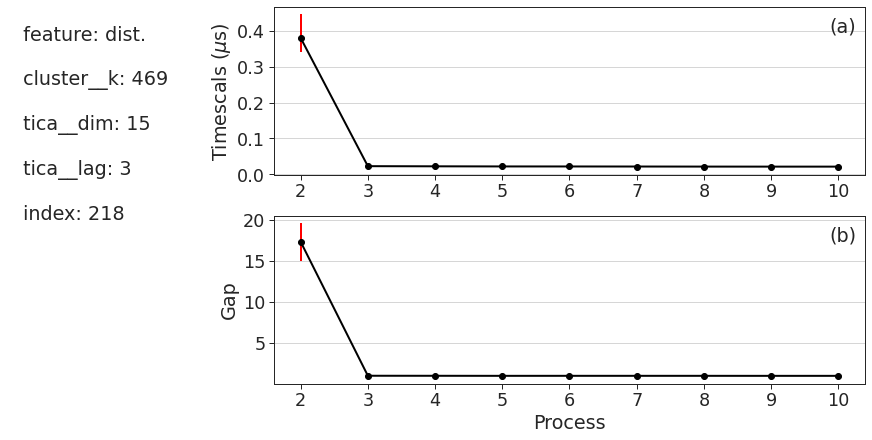

In [155]:
# Figure 2 : HP table + TS + TS gap

with sns.plotting_context('paper', font_scale=2):
    fig = plt.figure(figsize=(12, 6), constrained_layout=True)
    gs = fig.add_gridspec(nrows=6, ncols=12)
    
    ax1 = fig.add_subplot(gs[:, :3])
    ax1.text(0.05, 0.95, str_to_print, transform=ax1.transAxes, verticalalignment='top')
    
    ax1.axis('off')

    
    ax2 = fig.add_subplot(gs[:3, 3:])
    x = np.arange(n_ts-1)+2
    y = ts_median
    yerr = (ts_median-ts_lb, ts_ub-ts_median)
    ax2.errorbar(x, y, yerr, elinewidth=2, lw=2, marker='o', markersize=6, ecolor='r', c='k')
    
    ax2.set_ylabel(r"Timescals ($\mu$s)")
    ax2.tick_params(bottom=True, top=False, left=True, right=False)
    ax2.annotate(text='(a)', xy=(0.94, 0.94), xycoords='axes fraction', ha='left', va='top')
    ax2.grid(visible=True, axis='y')

    
    ax3 = fig.add_subplot(gs[3:, 3:])
    y = gap_median
    yerr = (gap_median-gap_lb, gap_ub-gap_median)
    ax3.errorbar(x, y, yerr, elinewidth=2, lw=2, marker='o', markersize=6, ecolor='r', c='k')
    
    ax3.set_ylabel("Gap")
    ax3.set_xlabel('Process')
    ax3.tick_params(bottom=True, top=False, left=True, right=False)
    ax3.annotate(text='(b)', xy=(0.94, 0.94), xycoords='axes fraction', ha='left', va='top')
    ax3.grid(visible=True, axis='y')

    plt.savefig(fig_dir.joinpath('SI_fig1.png'), bbox_inches='tight')

---
### Validate single MSM --- Figure 1

In [ ]:
# Validate a single trial
for i in range(n_bootstraps):
    ftrajs = ftrajs_all
    assert len(ftrajs) == len(ftrajs_all)
    
    ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
    dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)
    
    if n_bootstraps>1:
        out_dir = Path.joinpath(base_dir, Path(f'bs_{i}'))
    else:
        out_dir = Path.joinpath(base_dir, Path(f'dtrajs'))
        
    out_dir.mkdir(parents=True, exist_ok=True)
    
    for j in range(len(traj_paths)): 
        traj_path = Path(traj_paths[j]).resolve()
        np.save(file=out_dir.joinpath(traj_path.with_suffix('.npy').name), arr=dtrajs[j])
        
msm = pm.msm.estimate_markov_model(dtrajs, lag=lag)
_ = msm.pcca(n_sets)
ts = msm.timescales(n_ts)

In [ ]:
# Compute PCCA population

print('\nstate\tπ\t\tG/kT\t\tNo.')
population = []
number = []
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    population.append(p)
    number.append(s.shape[0])
    print('{}\t{:f}\t{:f}\t{}'.format(i, p, -np.log(p), s.shape[0]))

In [ ]:
# Compute core set 

ix_ls = []
core_memberships = msm.metastable_memberships.T > 0.95
for i in range(len(core_memberships)):
    ix_ls.append(np.where(core_memberships[i])[0])
core_sets = np.array(ix_ls)

# Compute MFPT between core sets

mfpt = np.zeros((n_sets, n_sets))
for i, j in product(range(n_sets), repeat=2):
    mfpt[i, j] = msm.mfpt(core_sets[i], core_sets[j])

mfpt_df = pd.DataFrame(np.round(mfpt, decimals=2), index=range(1, n_sets + 1), columns=range(1, n_sets + 1))
print(mfpt_df, '\n(ns)')

In [ ]:
# Map reference conformation

test_traj_path = r'../../../chignolin/5AWL_H.pdb'
test_labels = '5AWL'
ftraj_test = featurizer(hps.loc[hp_ix, :].to_dict(), test_traj_path, top_path)
ftraj_test_tica = tica_mod.transform(ftraj_test)
microstate = kmeans_mod.assign(ftraj_test_tica)
metastate = msm.metastable_assignments[microstate]
test_dict = {label:[test_traj_path[i], microstate[i][0], metastate[i][0]] for i, label in enumerate(test_labels)}